# Functions

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from torch.utils.data import Dataset
from PIL import Image
import csv
from torchvision import transforms, models
import json
import seaborn as sns
from sklearn.metrics import matthews_corrcoef, f1_score
import random
import torch.optim as optim
from torch.optim import lr_scheduler


# 设置随机数种子
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# 设置CUDA随机数种子（如果使用GPU）
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# json train
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['ImagePath']
        label = item['Label']

        # Load image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert label to numerical representation
        if label == 'NFF':
            label = 0
        elif label == 'AFF':
            label = 1
        else:
            raise ValueError("Invalid label in JSON data.")

        return image, label
    
# csv
class CustomCsvDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.hospital_ids = []  # Store hospital IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']
                hospital_id = row['HospitalID']

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)
                self.hospital_ids.append(int(hospital_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff

def test_model(model, test_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()

    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    # Check if total_aff is zero before performing the division
    test_accuracy_nff = correct_test_nff / total_nff if total_nff != 0 else 0
    test_accuracy_aff = correct_test_aff / total_aff if total_aff != 0 else 0
    test_accuracy_total = (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Directly use class labels as strings in target_names
    target_names = ['NFF', 'AFF']

    classification_rep = classification_report(all_labels, all_predictions)

    # Calculate AUC
    auc_score = roc_auc_score(all_labels, all_predictions)

    # Calculate Matthew's correlation coefficient
    mcc_score = matthews_corrcoef(all_labels, all_predictions)

    # Calculate F1 score
    f1_score_value = f1_score(all_labels, all_predictions)

    # Store metrics in a dictionary
    metrics = {
        # "Test Loss": round(test_loss, 3),
        "Total Acc": round(test_accuracy_total, 3),
        "nff Acc": round(test_accuracy_nff, 3),
        "aff Acc": round(test_accuracy_aff, 3),
        "AUC": round(auc_score, 3),
        "MCC": round(mcc_score, 3),
        "F1 Score": round(f1_score_value, 3),
    }

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_rep)

    return metrics
# ------------------------------------------------------------------------------------------------------
def train_custom_model(model, train_dataset, val_dataset, num_epochs, batch_size, optimizer=None):
    classweight = get_classweight(train_dataset)  # get_classweight is a function defined above
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define the optimizer
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can change the optimizer and initial learning rate

    # Define the learning rate scheduler
    lr_scheduler_step_size = 10
    lr_scheduler_gamma = 0.1
    scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()

        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train ACC: {train_accuracy:.2f}%, "
              f"Validation ACC: {validation_accuracy:.2f}%")

        # Store accuracies for plotting
        train_accuracies.append(train_accuracy)
        val_accuracies.append(validation_accuracy)

        # Step the learning rate scheduler
        scheduler.step()

    # Plotting the accuracy curves
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model



In [9]:
# augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load JSON data
with open('/local/data1/honzh073/local_repository/FL/code/4_centralized_learning/csv_files/combined_data1.json', 'r') as json_file:
    json_data = json.load(json_file)
    train_data = json_data['train']
    val_data = json_data['val']

train_dataset = CustomDataset(train_data, transform=train_transforms)
val_dataset = CustomDataset(val_data, transform=val_transforms)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# # # print images
# # show_image(train_dataset, 5)

# # calculate numbers
# print("train")
# print('-----------------------------------')
# train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
# train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

# print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
# print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")

# print("val")
# print('-----------------------------------')
# train_NFF_count = sum(1 for _, label in val_dataset if label == 0)  # 0 NFF
# train_AFF_count = sum(1 for _, label in val_dataset if label == 1)  # 1 AFF

# print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
# print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")


training class weight [0.6863799283154122, 1.8413461538461537]


# VGG 19

Epoch 1/100, Train ACC: 53.79%, Validation ACC: 48.81%
Epoch 2/100, Train ACC: 64.49%, Validation ACC: 57.74%
Epoch 3/100, Train ACC: 63.45%, Validation ACC: 71.43%
Epoch 4/100, Train ACC: 60.05%, Validation ACC: 30.95%
Epoch 5/100, Train ACC: 76.24%, Validation ACC: 66.07%
Epoch 6/100, Train ACC: 78.33%, Validation ACC: 71.43%
Epoch 7/100, Train ACC: 81.46%, Validation ACC: 76.19%
Epoch 8/100, Train ACC: 84.86%, Validation ACC: 77.38%
Epoch 9/100, Train ACC: 83.81%, Validation ACC: 74.40%
Epoch 10/100, Train ACC: 84.33%, Validation ACC: 83.93%
Epoch 11/100, Train ACC: 88.25%, Validation ACC: 83.93%
Epoch 12/100, Train ACC: 87.99%, Validation ACC: 80.36%
Epoch 13/100, Train ACC: 87.73%, Validation ACC: 79.17%
Epoch 14/100, Train ACC: 90.34%, Validation ACC: 82.74%
Epoch 15/100, Train ACC: 90.08%, Validation ACC: 81.55%
Epoch 16/100, Train ACC: 92.17%, Validation ACC: 77.38%
Epoch 17/100, Train ACC: 91.12%, Validation ACC: 79.17%
Epoch 18/100, Train ACC: 92.69%, Validation ACC: 77.98%
E

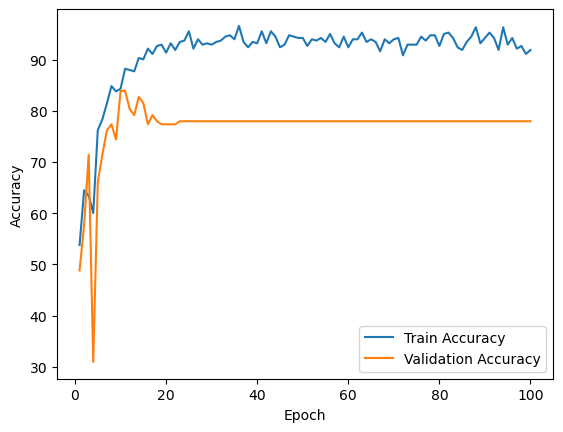

In [3]:
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the VGG-19 model
model = models.vgg19(weights=VGG19_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.features.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 100
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

v19 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


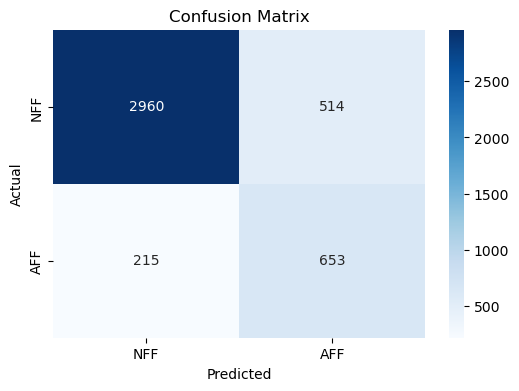

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      3474
           1       0.56      0.75      0.64       868

    accuracy                           0.83      4342
   macro avg       0.75      0.80      0.77      4342
weighted avg       0.86      0.83      0.84      4342



{'Total Acc': 0.832,
 'nff Acc': 0.852,
 'aff Acc': 0.752,
 'AUC': 0.802,
 'MCC': 0.545,
 'F1 Score': 0.642}

In [4]:
model = v19
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# ResNet50

Epoch 1/100, Train ACC: 50.39%, Validation ACC: 66.07%


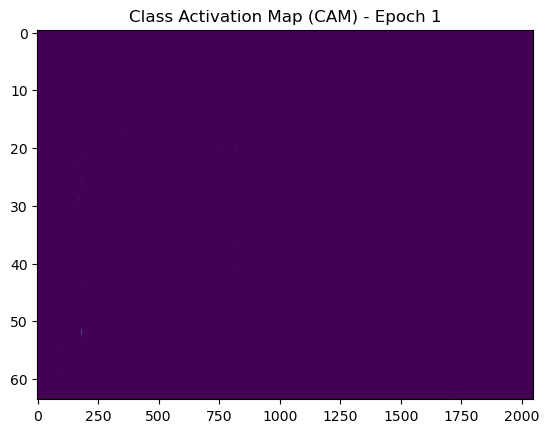

Epoch 2/100, Train ACC: 63.19%, Validation ACC: 66.67%


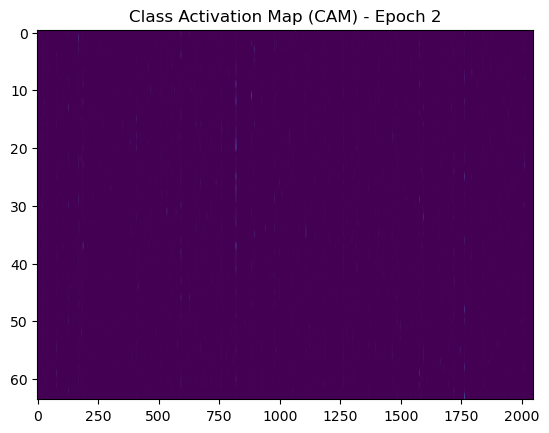

Epoch 3/100, Train ACC: 68.15%, Validation ACC: 52.98%


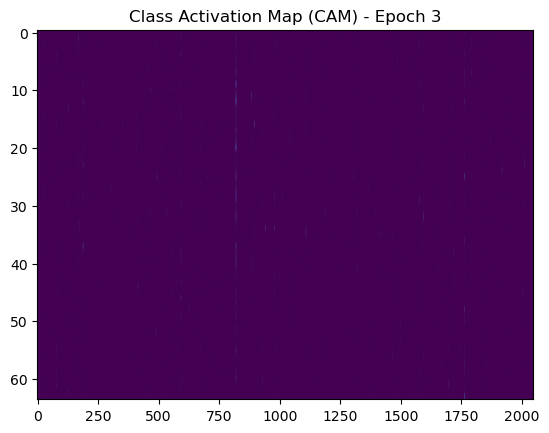

Epoch 4/100, Train ACC: 72.85%, Validation ACC: 59.52%


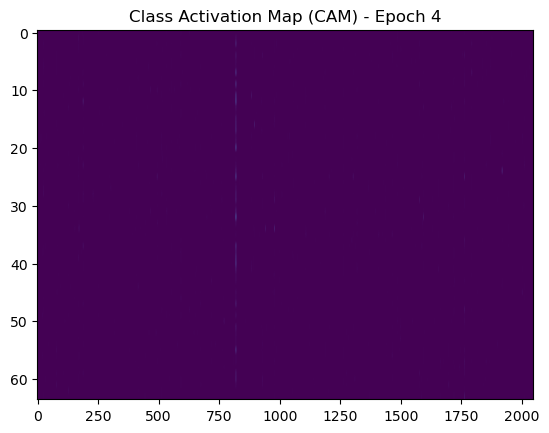

Epoch 5/100, Train ACC: 74.15%, Validation ACC: 69.64%


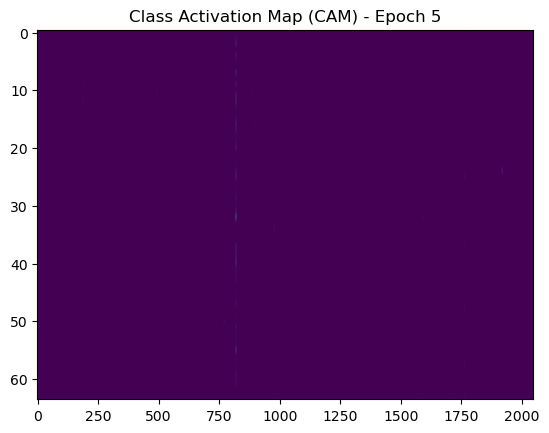

Epoch 6/100, Train ACC: 80.16%, Validation ACC: 78.57%


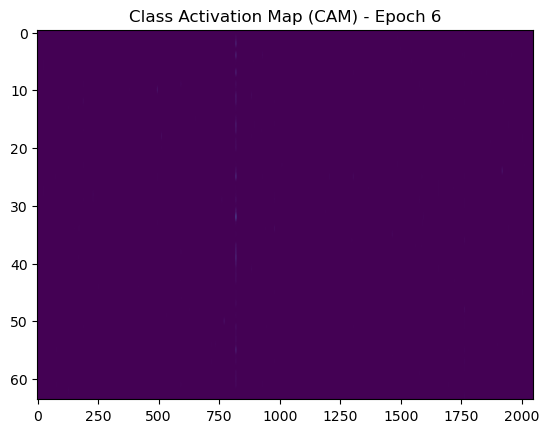

Epoch 7/100, Train ACC: 84.33%, Validation ACC: 81.55%


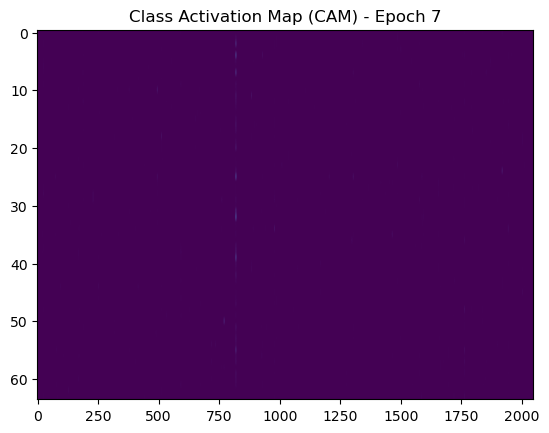

Epoch 8/100, Train ACC: 82.77%, Validation ACC: 83.33%


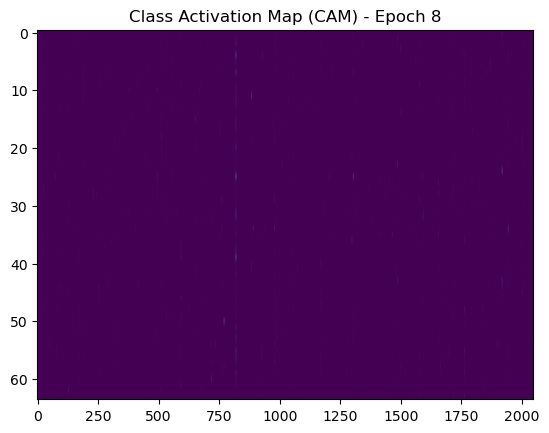

Epoch 9/100, Train ACC: 87.21%, Validation ACC: 80.36%


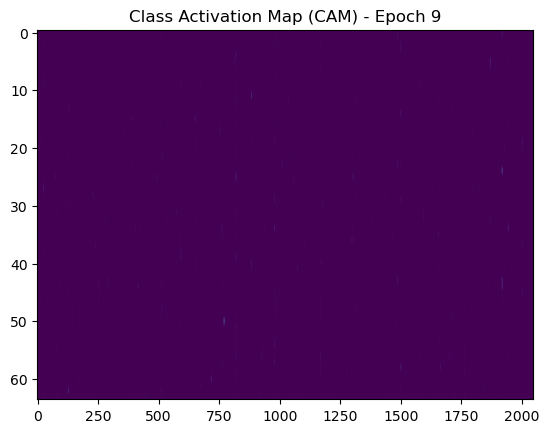

Epoch 10/100, Train ACC: 89.03%, Validation ACC: 82.74%


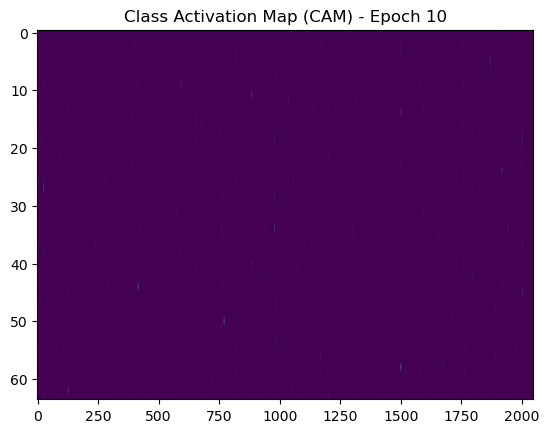

Epoch 11/100, Train ACC: 89.82%, Validation ACC: 81.55%


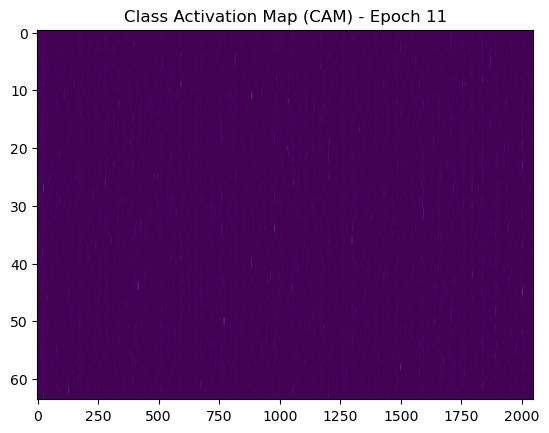

Epoch 12/100, Train ACC: 90.34%, Validation ACC: 82.74%


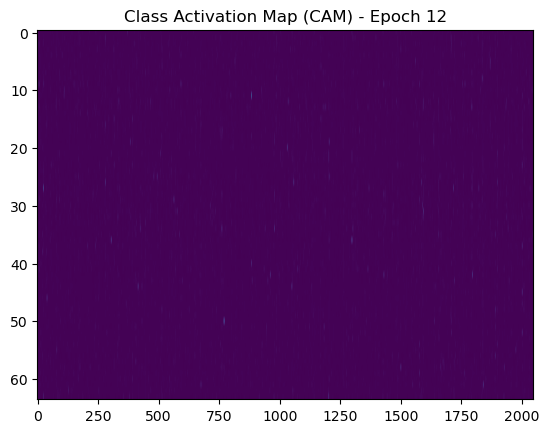

Epoch 13/100, Train ACC: 92.43%, Validation ACC: 80.36%


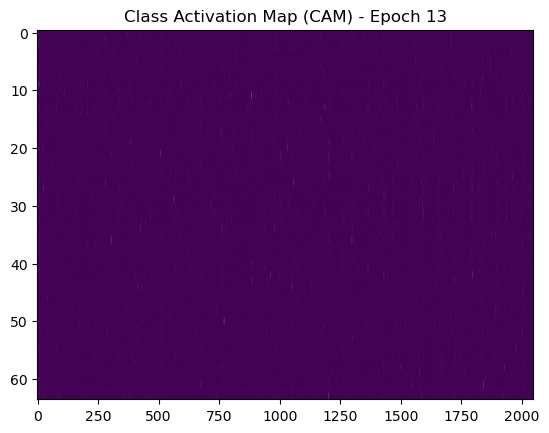

Epoch 14/100, Train ACC: 91.12%, Validation ACC: 80.36%


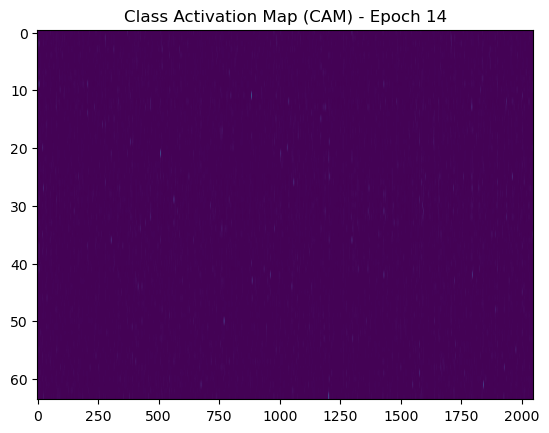

Epoch 15/100, Train ACC: 90.08%, Validation ACC: 78.57%


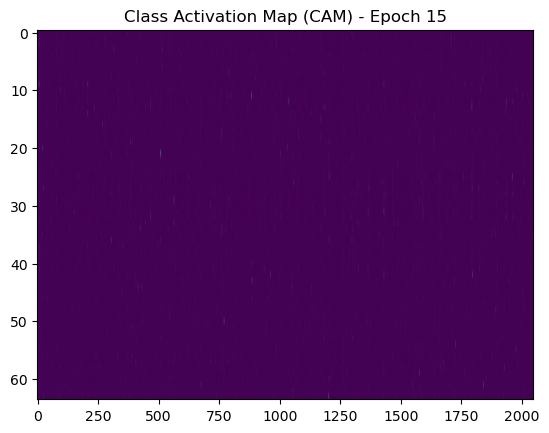

Epoch 16/100, Train ACC: 92.43%, Validation ACC: 78.57%


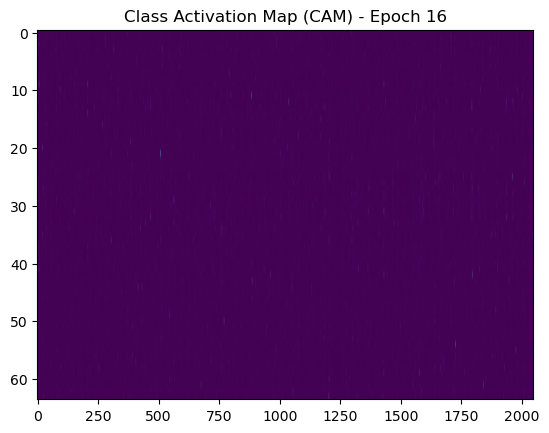

Epoch 17/100, Train ACC: 91.91%, Validation ACC: 78.57%


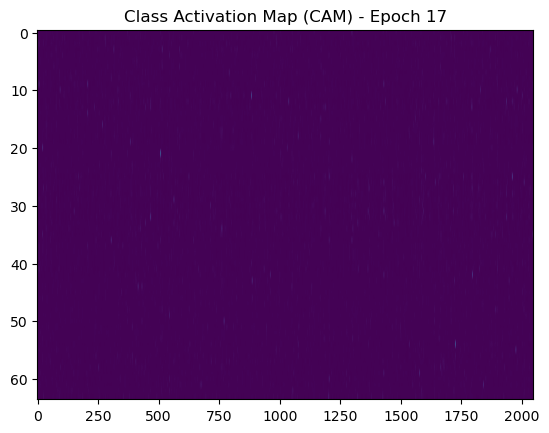

Epoch 18/100, Train ACC: 90.86%, Validation ACC: 77.98%


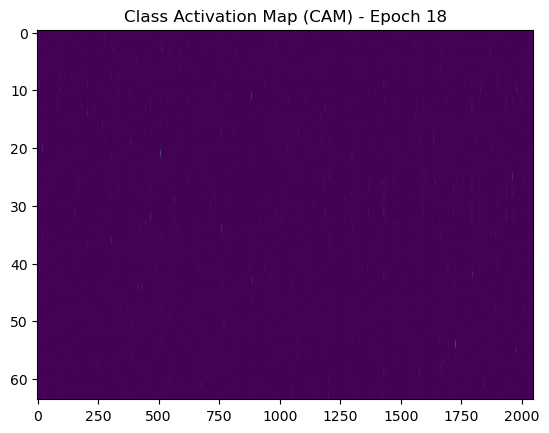

Epoch 19/100, Train ACC: 92.43%, Validation ACC: 79.76%


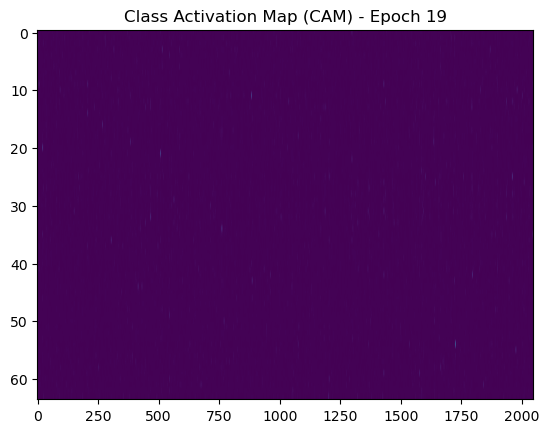

Epoch 20/100, Train ACC: 94.26%, Validation ACC: 79.76%


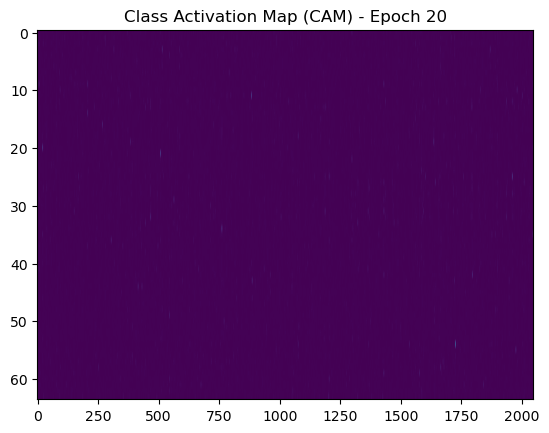

Epoch 21/100, Train ACC: 91.38%, Validation ACC: 79.17%


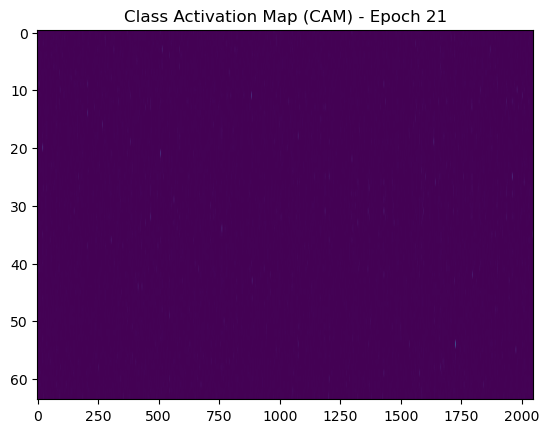

Epoch 22/100, Train ACC: 93.99%, Validation ACC: 81.55%


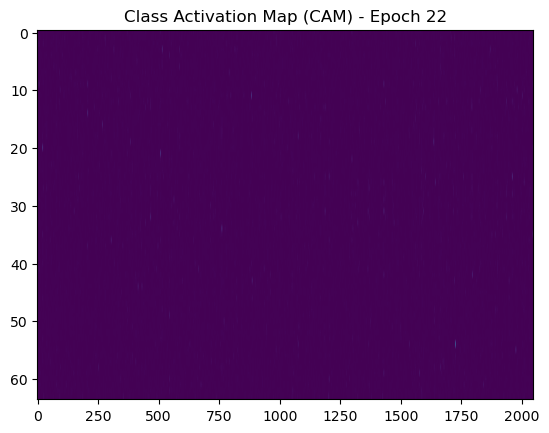

Epoch 23/100, Train ACC: 91.12%, Validation ACC: 80.95%


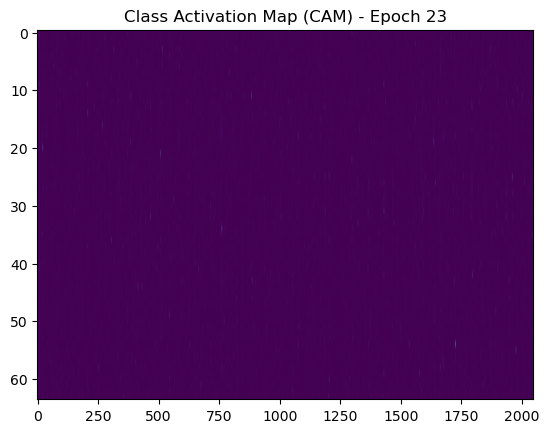

Epoch 24/100, Train ACC: 92.69%, Validation ACC: 81.55%


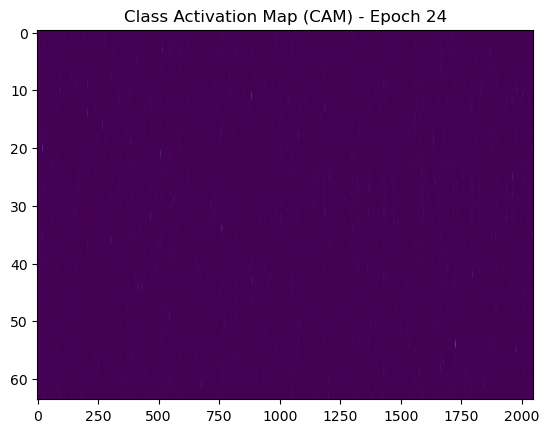

Epoch 25/100, Train ACC: 92.95%, Validation ACC: 80.36%


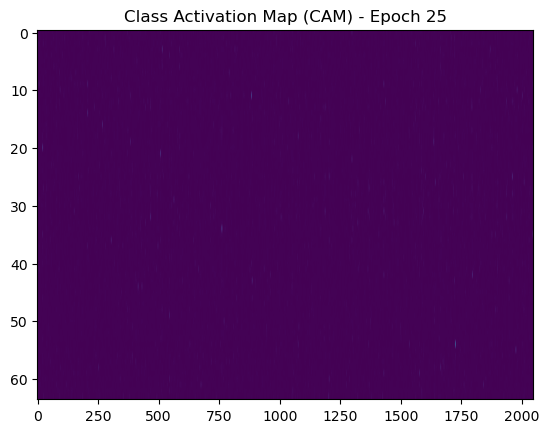

Epoch 26/100, Train ACC: 94.78%, Validation ACC: 80.95%


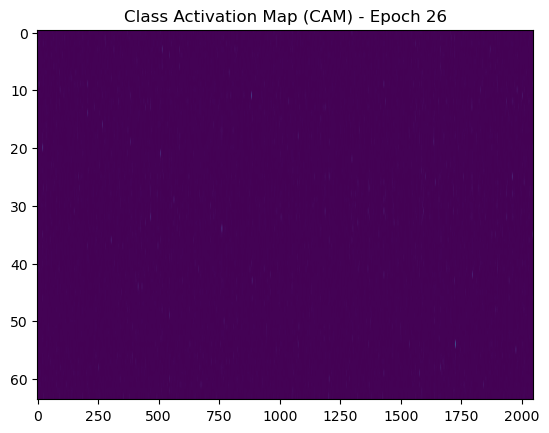

Epoch 27/100, Train ACC: 92.69%, Validation ACC: 80.95%


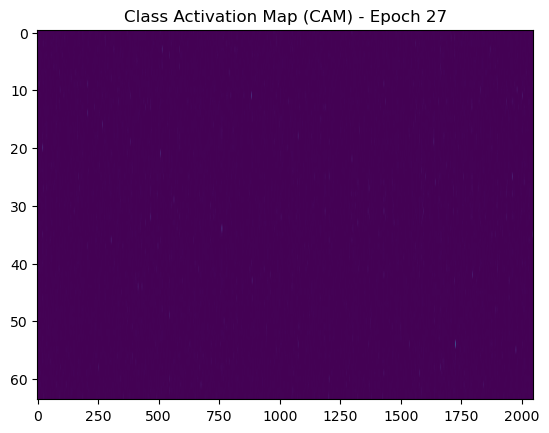

Epoch 28/100, Train ACC: 95.04%, Validation ACC: 80.36%


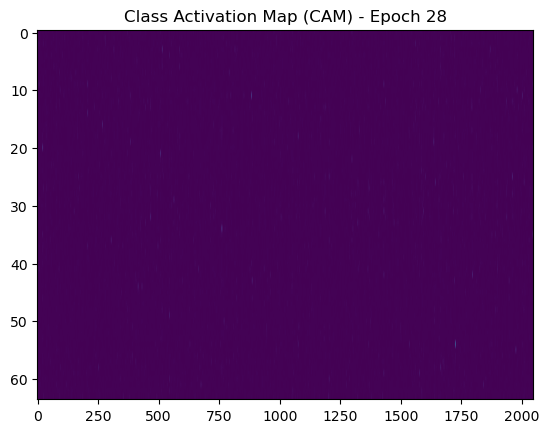

Epoch 29/100, Train ACC: 94.26%, Validation ACC: 80.95%


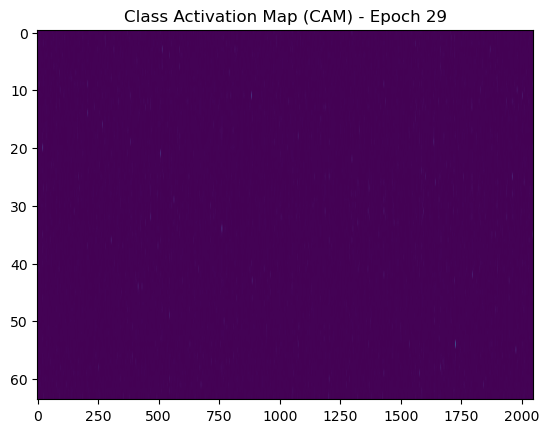

Epoch 30/100, Train ACC: 92.69%, Validation ACC: 80.36%


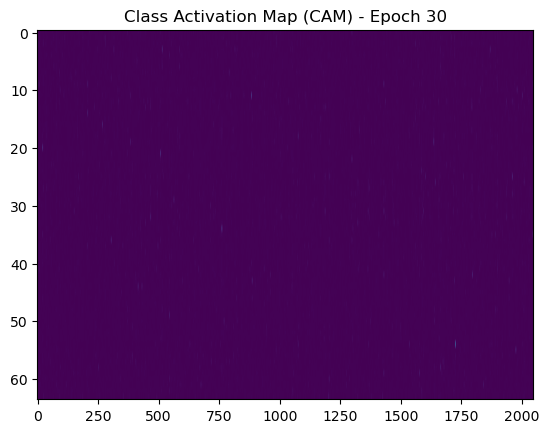

Epoch 31/100, Train ACC: 92.95%, Validation ACC: 80.36%


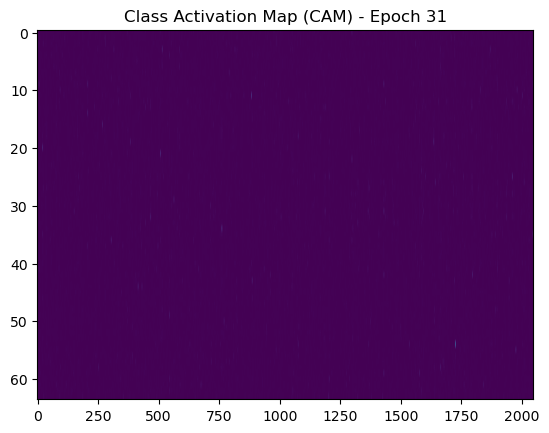

Epoch 32/100, Train ACC: 95.30%, Validation ACC: 82.74%


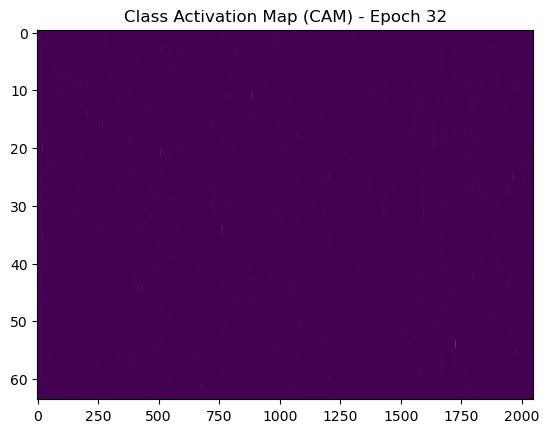

KeyboardInterrupt: 

In [14]:
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 100
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res50 = train_custom_model_with_visualization(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



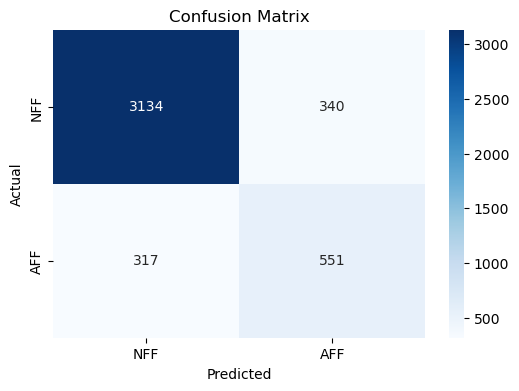

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      3474
           1       0.62      0.63      0.63       868

    accuracy                           0.85      4342
   macro avg       0.76      0.77      0.77      4342
weighted avg       0.85      0.85      0.85      4342



{'Total Acc': 0.849,
 'nff Acc': 0.902,
 'aff Acc': 0.635,
 'AUC': 0.768,
 'MCC': 0.532,
 'F1 Score': 0.626}

In [6]:
model = res50
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# ResNet101

Epoch 1/100, Train ACC: 61.36%, Validation ACC: 46.43%
Epoch 2/100, Train ACC: 67.62%, Validation ACC: 52.38%
Epoch 3/100, Train ACC: 67.36%, Validation ACC: 63.10%
Epoch 4/100, Train ACC: 72.85%, Validation ACC: 70.83%
Epoch 5/100, Train ACC: 74.41%, Validation ACC: 68.45%
Epoch 6/100, Train ACC: 77.02%, Validation ACC: 72.02%
Epoch 7/100, Train ACC: 83.03%, Validation ACC: 77.38%
Epoch 8/100, Train ACC: 87.99%, Validation ACC: 83.33%
Epoch 9/100, Train ACC: 87.73%, Validation ACC: 78.57%
Epoch 10/100, Train ACC: 90.08%, Validation ACC: 81.55%
Epoch 11/100, Train ACC: 91.64%, Validation ACC: 80.36%
Epoch 12/100, Train ACC: 95.56%, Validation ACC: 79.76%
Epoch 13/100, Train ACC: 92.17%, Validation ACC: 79.76%
Epoch 14/100, Train ACC: 91.38%, Validation ACC: 79.17%
Epoch 15/100, Train ACC: 93.47%, Validation ACC: 80.95%
Epoch 16/100, Train ACC: 93.21%, Validation ACC: 82.14%
Epoch 17/100, Train ACC: 96.08%, Validation ACC: 84.52%
Epoch 18/100, Train ACC: 93.47%, Validation ACC: 83.93%
E

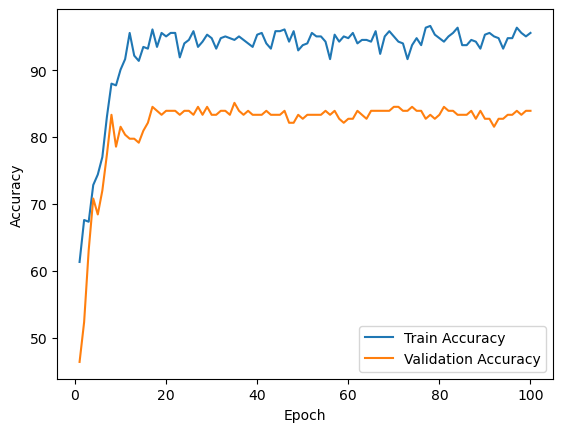

In [7]:
from torchvision.models import resnet101, ResNet101_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the ResNet-101 model
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)


# layer number
total_layers = len(list(model.children()))

# freeze 50% layer
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False

# modify full connection layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 100
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

res101 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)



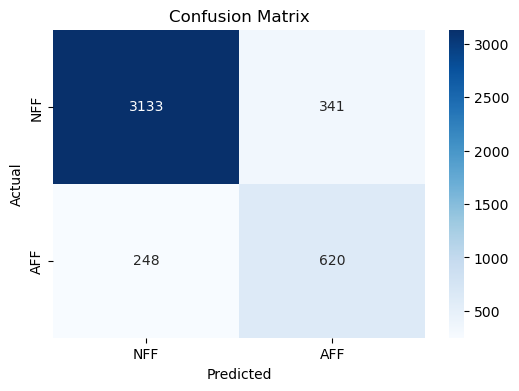

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3474
           1       0.65      0.71      0.68       868

    accuracy                           0.86      4342
   macro avg       0.79      0.81      0.80      4342
weighted avg       0.87      0.86      0.87      4342



{'Total Acc': 0.864,
 'nff Acc': 0.902,
 'aff Acc': 0.714,
 'AUC': 0.808,
 'MCC': 0.594,
 'F1 Score': 0.678}

In [8]:
model = res101
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# DenseNet 161

Epoch 1/100, Train ACC: 60.57%, Validation ACC: 53.57%
Epoch 2/100, Train ACC: 69.19%, Validation ACC: 54.17%
Epoch 3/100, Train ACC: 73.89%, Validation ACC: 46.43%
Epoch 4/100, Train ACC: 84.86%, Validation ACC: 54.76%
Epoch 5/100, Train ACC: 88.77%, Validation ACC: 66.67%
Epoch 6/100, Train ACC: 90.60%, Validation ACC: 77.98%
Epoch 7/100, Train ACC: 93.21%, Validation ACC: 82.14%
Epoch 8/100, Train ACC: 96.34%, Validation ACC: 84.52%
Epoch 9/100, Train ACC: 95.30%, Validation ACC: 85.12%
Epoch 10/100, Train ACC: 97.39%, Validation ACC: 88.10%
Epoch 11/100, Train ACC: 98.43%, Validation ACC: 88.10%
Epoch 12/100, Train ACC: 98.17%, Validation ACC: 88.69%
Epoch 13/100, Train ACC: 97.65%, Validation ACC: 88.69%
Epoch 14/100, Train ACC: 98.96%, Validation ACC: 87.50%
Epoch 15/100, Train ACC: 99.74%, Validation ACC: 87.50%
Epoch 16/100, Train ACC: 98.43%, Validation ACC: 87.50%
Epoch 17/100, Train ACC: 98.96%, Validation ACC: 88.10%
Epoch 18/100, Train ACC: 97.65%, Validation ACC: 88.10%
E

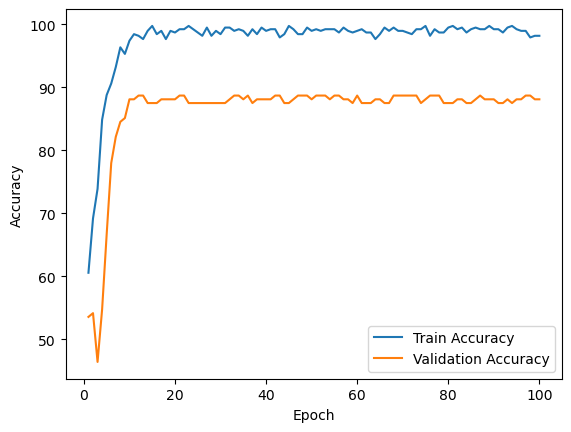

In [3]:
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Define the DenseNet-161 model
model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

# Modify the classifier part of the model
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

# total layers 
total_layers = len(list(model.features.children()))

# freeze 50% layers
freeze_layers = int(total_layers * 0.5)
for index, child in enumerate(model.features.children()):
    if index < freeze_layers:
        for param in child.parameters():
            param.requires_grad = False
            
# ---------------------------------------------------------------------------------------------------------
# Hyper parameters
num_epochs = 100
batch_size = 64
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# ---------------------------------------------------------------------------------------------------------

dense161 = train_custom_model(model, train_dataset, val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)


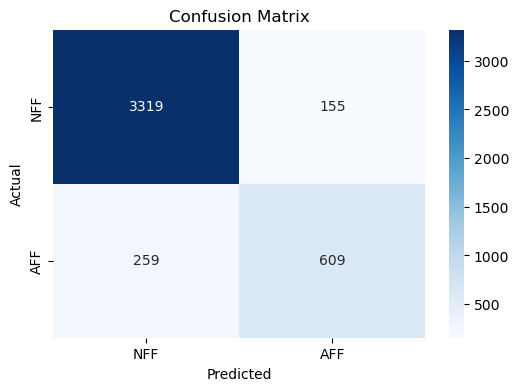

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3474
           1       0.80      0.70      0.75       868

    accuracy                           0.90      4342
   macro avg       0.86      0.83      0.84      4342
weighted avg       0.90      0.90      0.90      4342



{'Total Acc': 0.905,
 'nff Acc': 0.955,
 'aff Acc': 0.702,
 'AUC': 0.828,
 'MCC': 0.69,
 'F1 Score': 0.746}

In [4]:
model = dense161
model.eval()
# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomCsvDataset(csv_file=test_csv_file, transform=test_transform)

test_model(model, test_dataset)

# Efficient B2

In [ ]:
# from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# # Define the EfficientNetV2-M model
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)

# # Access input features of the classifier
# num_features = model.classifier[1].in_features

# # Modify the classifier part of the model
# model.classifier[1] = nn.Linear(in_features=num_features, out_features=2)

# # Freeze certain layers
# total_layers = len(list(model.children()))
# freeze_layers = int(total_layers * 0.5)
# for index, child in enumerate(model.children()):
#     if index < freeze_layers:
#         for param in child.parameters():
#             param.requires_grad = False

# # Hyperparameters
# num_epochs = 20
# batch_size = 64
# learning_rate = 0.0001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Move model to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # Train the model
# effi_b2 = train_custom_model(model, train_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer)
